In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re
from scipy.special import erf, erfinv

from matplotlib.lines import Line2D


seed = 100201138
ga = 1664525
gc = 1013904223
gm = 2**32

english_colonies = ['EGY', 'KEN', 'NGA', 'ZAF', 'ZMB', 'ZWE', 'MUS']
french_colonies = ['DZA', 'CIV', 'CAF', 'MAR', 'TUN']
portuguese_colonies = ['AGO']

def randint(a, c, m):
    global seed
    seed = (a * seed + c) % m
    return seed


def rand():
    rand = randint(ga, gc, gm)
    return float(rand) / gm

def randnorm(mu, sigma):
    return (mu+sigma*2**0.5*erfinv(2*rand()-1))

def customMean(values):
    total = 0
    for v in values:
        total += v
    return total / len(values)

def customStd(data):
    mean = customMean(data)
    var = 0
    for v in [(h-mean)**2 for h in data]:
        var += v
    var = var/len(data)
    std = var**0.5
    return std
       
def percentile(values, alpha):
    sortedvalues = quickSort(values)
    if alpha >= 1.0:
        return sortedvalues[len(sortedvalues)-1]
    if alpha < 0.0:
        return sortedvalues[0]
    index = int(alpha*len(values)-0.5)
    return sortedvalues[index]

def quickSort(values):
    smaller = []
    larger = []
    equal = []
    if (len(values) <= 1):
        return values
    pivot = values[0]
    for val in values:
        if val < pivot:
            smaller += [val]
        elif val > pivot:
            larger += [val]
        else:
            equal += [val]
    smaller = quickSort(smaller)
    larger = quickSort(larger)
    return smaller + equal + larger

In [3]:
crises_df = pd.read_csv('data/african_crises.csv')
crises_df = crises_df.replace({'banking_crisis': {'crisis': 1, 'no_crisis': 0}})
print(crises_df.isnull().sum())
print()
for index, col in enumerate(crises_df.columns):
    print(index, col)

case                               0
cc3                                0
country                            0
year                               0
systemic_crisis                    0
exch_usd                           0
domestic_debt_in_default           0
sovereign_external_debt_default    0
gdp_weighted_default               0
inflation_annual_cpi               0
independence                       0
currency_crises                    0
inflation_crises                   0
banking_crisis                     0
dtype: int64

0 case
1 cc3
2 country
3 year
4 systemic_crisis
5 exch_usd
6 domestic_debt_in_default
7 sovereign_external_debt_default
8 gdp_weighted_default
9 inflation_annual_cpi
10 independence
11 currency_crises
12 inflation_crises
13 banking_crisis


In [4]:
startingyear = 1960

countries = {}
for row in crises_df.values:
    if row[1] not in countries:
        countries[row[1]] = {}
    if row[3]>= startingyear:
        year = math.floor(row[3]/10)*10
        if year not in countries[row[1]]:
            countries[row[1]][year] = {}
            
        for index in range(4, 13):
            if crises_df.columns[index] not in countries[row[1]][year]:
                countries[row[1]][year][crises_df.columns[index]] = []
                
            countries[row[1]][year][crises_df.columns[index]] += [row[index]]
            

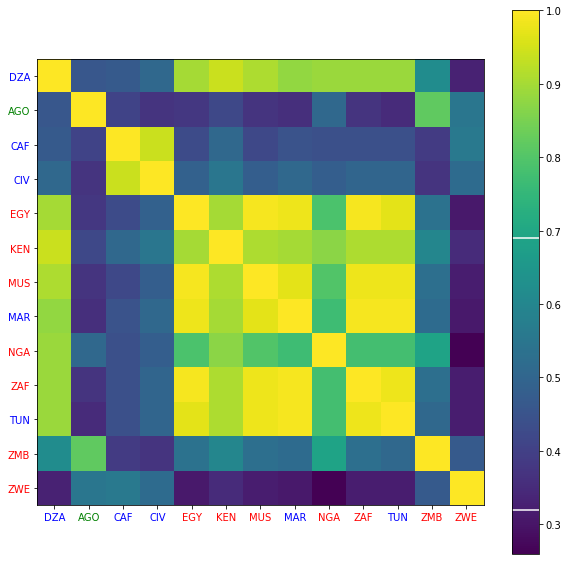

In [91]:
def kmeansclustering(data, k, p):
    randompointParameters = generateRandomPointParameters(data)
    cluster = {}
    randompoints = []
    for i in range(k):
        randompoints += [generaterandompoint(randompointParameters)]
        cluster[i] = []
    
    diff = -1
    while (diff != 0):   
        for key in cluster.keys():
            cluster[key] = []

        for country in data:
            shortestDistance = 100000000
            clusterpoint = None
            for pointIndex in cluster.keys():
                dist = distance(country, randompoints[pointIndex])
                if dist < shortestDistance:
                    shortestDistance = dist
                    clusterpoint = pointIndex
            cluster[clusterpoint] += [country]
        
        if p:
            for key in cluster.keys():
                print(key, "-", len(cluster[key]))
        
        diff = 0
        for key in cluster.keys():
            if len(cluster[key]) > 0:
                parameters = generateRandomPointParameters(cluster[key])
                newpoint = {}
                for period in parameters.keys():
                    if period not in newpoint:
                        newpoint[period] = {}
                    for metric in parameters[period].keys():
                        newval = parameters[period][metric][0]
                        newpoint[period][metric] = newval

                        if period in randompoints[key].keys():
                            oldval = randompoints[key][period][metric]
                        else:
                            oldval = 0
                        diff += (abs(oldval-newval))
                randompoints[key] = newpoint
            else:
                randompoints[key] = generaterandompoint(randompointParameters)            
        if p:
            print("totalchange:", diff)
    
    for values in list(cluster.values()):
        if len(values) == 0:
            return kmeansclustering(data, k , p)
    return cluster, randompoints

def generateRandomPointParameters(data):
    counts = {}
    for country in data:
        for period in country.keys():
            if period not in counts:
                counts[period] = {}
            for metric in country[period].keys():
                if metric in counts[period]:
                    counts[period][metric] += [country[period][metric]]
                else:
                    counts[period][metric] = [country[period][metric]]
    
    parameters = {}
    for period in counts.keys():
        if period not in parameters:
            parameters[period] = {}
            for metric in counts[period].keys():
                means = [customMean(country) for country in counts[period][metric]]
                mean = customMean(means)
                std = customStd(means)
                parameters[period][metric] = (mean, std)
    return parameters

def generaterandompoint(parameters):
    randomCountry = {}
    for period in parameters.keys():
        if period not in randomCountry:
            randomCountry[period] = {}
        for metric in parameters[period].keys():
            randomCountry[period][metric] = randnorm(parameters[period][metric][0], parameters[period][metric][1])
    return randomCountry

def distance(country1, country2):
    difs = []
    for period in country1.keys():
        for metric in country1[period].keys():
            val = diff(customMean(country1[period][metric]), country2[period][metric])
            difs += [val]
    total = 0
    
    for dif in difs:
        total += dif**2
    return total**0.5
            
def diff(val1, val2):
    return abs(val1 - val2)


def removeMetrics(data, metrics):
    for metric in metrics:
        for country in data:
            for period in country.keys():
                country[period].pop(metric, None)
    return data

def getdictindex(dictionary, data, countries):
    for index, data in enumerate(data):
        if data == dictionary:
            return list(countries.keys())[index]
    return -1
    
def parseclusterresult(cluster, data, countries):
    result = []
    for key in cluster.keys():
        clust = []
        for val in cluster[key]:
            clust += [getdictindex(val, data, countries)]
        result += [clust]
    return result

def createresdict(clusterresults, countries):
    resultdict = {}
    for country in countries.keys():
        resultdict[country] = {}
    for clusters in clusterresults:
        for cluster in clusters:
            for country in countries.keys():
                if country in cluster:
                    for countrycode in cluster:
                        if countrycode != country:
                            if countrycode not in resultdict[country]:
                                resultdict[country][countrycode] = 1
                            else:
                                resultdict[country][countrycode] += 1
                                
    return resultdict
                
def visualizeresults(resultdict, n):
    for country in resultdict.keys():
        plt.figure()
        tempcountry,_ = getColonizer(country)
        plt.title(str(country) + ": " + tempcountry)
        legend = []
        for refcountry in resultdict[country].keys():
            percentage = resultdict[country][refcountry]/n
            tempcountry, color = getColonizer(refcountry)
            plt.plot([percentage, percentage], [0,1], label=tempcountry, color=color)
            legend += [str(refcountry) + ":" + tempcountry]
        plt.legend(legend)
        plt.show()
        
def getColonizer(country):
    if country in english_colonies:
        return 'GBR', 'r'
    elif country in french_colonies:
        return 'FRA', 'b'
    elif country in portuguese_colonies:
        return 'PRT', 'g'
    else:
        return 'UNKNOWN', 'b'

def distancematrix(resultdict, n):
    matrix = []
    countrylst = resultdict.keys()
    for country in countrylst:
        row = []
        for refcountry in countrylst:
            if refcountry in resultdict[country]:
                row += [resultdict[country][refcountry]/n]
            else:
                row += [1]
        matrix += [row]
    return matrix, resultdict.keys()

def getcolorlist(countrylst):
    colorlist = []
    for country in countrylst:
        if country in english_colonies:
            colorlist += ['r']
        elif country in french_colonies:
            colorlist += ['b']
        else:
            colorlist += ['g']
    return colorlist

def plotmatrix(matrix, countrylst, colorlist):
    fig, ax = plt.subplots(1,1, figsize = [10,10])
    img = ax.imshow(matrix)
    ax.set_yticklabels(countrylst)
    ax.set_xticklabels(countrylst)
    
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
    plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
    for color, tick in zip(colorlist, ax.yaxis.get_major_ticks()):
        tick.label1.set_color(color)
    for color, tick in zip(colorlist, ax.xaxis.get_major_ticks()):
        tick.label1.set_color(color)
    plt.ylim(12.5, -0.5)
    cb = plt.colorbar(img)
    cb.ax.plot([0, 1], [0.32]*2, 'w')
    cb.ax.plot([0, 1], [0.69]*2, 'w')
    plt.savefig("ClusteringDistanceMatrix")
    plt.show()
    
            
        
data = []

for key in countries.keys():
    data += [countries[key]]    
    
data = removeMetrics(data, ['exch_usd', 'inflation_annual_cpi'])

k = 2
n = 100
    
clusters = [kmeansclustering(data, k, False)[0] for _ in range(n)]


clusterresults = []
for cluster in clusters:
    clusterresults += [parseclusterresult(cluster, data, countries)]

resultdict = createresdict(clusterresults, countries)
matrix, countrylst = distancematrix(resultdict, n)
colorlist = getcolorlist(countrylst)

plotmatrix(matrix, countrylst, colorlist)



In [74]:
def createBootstrappedData(data, n):
    randompointParameters = generateRandomPointParameters(data)
    randompoints = []
    for i in range(n):
        randompoints += [generaterandombootstrappoint(randompointParameters)]
        cluster[i] = []
    return randompoints

def generaterandombootstrappoint(parameters):
    randomCountry = {}
    for period in parameters.keys():
        if period not in randomCountry:
            randomCountry[period] = {}
        for metric in parameters[period].keys():
            randomCountry[period][metric] = [math.floor(randnorm(parameters[period][metric][0], parameters[period][metric][1])+0.5) for _ in range(10)]
    return randomCountry

    
n = 10**4
randompoints = createBootstrappedData(data, 25)

points = {}
for index, point in enumerate(randompoints):
    points[index] = point

bootstrapclusters = [kmeansclustering(randompoints, k, False)[0] for _ in range(n)]

bootstrapresults = []
for bootcluster in bootstrapclusters:
    bootstrapresults += [parseclusterresult(bootcluster, randompoints, points)]

bootdict = createresdict(bootstrapresults, points)    

In [75]:
ranks = []
for key in bootdict[0].keys():
    ranks += [bootdict[0][key] / n]

print("95 Percentile", percentile(ranks, 0.95))
print("5 Percentile", percentile(ranks, 0.05))



95 Percentile 0.6884
5 Percentile 0.3173
